# FCOS Fire/Smoke Detection Training

This notebook provides a complete training and visualization environment for the FCOS fire/smoke detection model. **Works both locally and on Google Colab!**

## Overview
- Automatic Colab setup (mounts Drive, installs dependencies)
- Load and inspect the detection dataset
- **Train the FCOS model** (all epochs at once)
- Visualize training progress
- Run inference and visualize predictions
- Evaluate model performance


In [1]:
# ============================================================================
# SETUP: Detect Colab and configure environment
# ============================================================================
import os
import sys
from pathlib import Path

# Detect if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("✓ Running locally")

# Colab-specific setup
if IN_COLAB:
    from google.colab import drive
    import subprocess

    # Mount Google Drive
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

    # ⚠️ UPDATE THIS PATH to match your Google Drive folder
    PROJECT_PATH = '/content/drive/MyDrive/fire-detection'
    os.chdir(PROJECT_PATH)

    # Setup paths first (needed for requirements.txt path)
    project_root = Path(PROJECT_PATH)
    sys.path.insert(0, str(project_root))
    sys.path.insert(0, str(project_root / 'fcos'))

    # Install dependencies
    print("Installing dependencies...")
    # Install PyTorch with CUDA support for Colab (must be first)
    subprocess.run(['pip', 'install', 'torch', 'torchvision', 'torchaudio',
                    '--index-url', 'https://download.pytorch.org/whl/cu118'],
                   check=False)
    # Install other dependencies from requirements.txt
    # Note: PyTorch packages are already installed above, so pip will skip them
    requirements_path = project_root / 'requirements.txt'
    if requirements_path.exists():
        subprocess.run(['pip', 'install', '-r', str(requirements_path)], check=False)
        print("✓ Installed dependencies from requirements.txt")
    else:
        # Fallback if requirements.txt not found
        subprocess.run(['pip', 'install', 'pillow', 'matplotlib', 'numpy', 'tensorboard'],
                       check=False)
        print("⚠️  requirements.txt not found, installed basic dependencies")

    print(f"✓ Colab setup complete!")
    print(f"  Project root: {project_root}")
else:
    # Local setup
    project_root = Path().resolve().parent
    sys.path.insert(0, str(project_root))
    sys.path.insert(0, str(project_root / 'fcos'))
    print(f"✓ Local setup complete!")
    print(f"  Project root: {project_root}")

# ============================================================================
# IMPORTS
# ============================================================================
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Import dataset and FCOS model
from fcos_dataset import FireSmokeDetectionDataset, collate_fn, create_dataloaders
from fcos import FCOS

# Import mapping functions from parent directory
from phase2_detection_metadata import metadata_to_fcos_class, fcos_to_metadata_class, LABEL_MAP

print("✓ All imports successful!")
if torch.cuda.is_available():
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  No GPU available - training will be slow")


✓ Running in Google Colab
Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Installing dependencies...
✓ Installed dependencies from requirements.txt
✓ Colab setup complete!
  Project root: /content/drive/MyDrive/fire-detection
✓ All imports successful!
✓ GPU available: Tesla T4


## 0. Generate Metadata (if needed)

In [2]:
# Check if metadata JSON exists, generate if missing
metadata_path = project_root / "dfire_detection_annotations.json"
dataset_dir = project_root / "D-Fire"

if metadata_path.exists():
    print(f"✓ Metadata file already exists: {metadata_path}")
    print("Skipping metadata generation.")
else:
    print("Metadata file not found. Generating it now...")

    # Check if dataset exists
    if not dataset_dir.exists():
        print(f"❌ Error: Dataset directory not found: {dataset_dir}")
        print("Please make sure the D-Fire dataset is in the project root.")
    else:
        # Check if phase2_detection_metadata.py exists
        metadata_script = project_root / "phase2_detection_metadata.py"
        RESAMPLE_PERCENT = 30
        if not metadata_script.exists():
            print(f"❌ Error: phase2_detection_metadata.py not found: {metadata_script}")
            print("Please make sure phase2_detection_metadata.py is in the project root.")
        else:
            # Generate metadata
            import subprocess
            print(f"Running: python phase2_detection_metadata.py ...")
            result = subprocess.run([
                'python', str(metadata_script),
                '--dataset-dir', str(dataset_dir),
                '--output', str(metadata_path),
                '--splits', 'train', 'test', 'validation',
                '--resample-percent', str(RESAMPLE_PERCENT)
            ], cwd=str(project_root), capture_output=True, text=True)

            if result.returncode == 0:
                if metadata_path.exists():
                    print(f"✓ Metadata generated successfully: {metadata_path}")
                else:
                    print("⚠️  Script ran but metadata file not found. Check errors above.")
            else:
                print(f"❌ Error generating metadata:")
                print(result.stderr)
                print(result.stdout)


✓ Metadata file already exists: /content/drive/MyDrive/fire-detection/dfire_detection_annotations.json
Skipping metadata generation.


## 1. Dataset Inspection


In [3]:
# Load metadata (automatically handles both local and Colab paths)
# Note: metadata_path should already be defined from the previous cell
if 'metadata_path' not in globals():
    metadata_path = project_root / "dfire_detection_annotations.json"

if not metadata_path.exists():
    raise FileNotFoundError(
        f"Metadata file not found: {metadata_path}\n"
        "Please run the previous cell to generate it, or run phase2_detection_metadata.py manually."
    )

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print("Dataset splits:", list(metadata["splits"].keys()))

for split_name, split_data in metadata["splits"].items():
    print(f"\n{split_name.upper()}:")
    print(f"  Images: {split_data['num_images']}")
    print(f"  Label distribution: {split_data['label_counts']}")

    # Count boxes by class
    fire_boxes = 0
    smoke_boxes = 0
    for entry in split_data["entries"]:
        for ann in entry["annotations"]:
            if ann["class_idx"] == 1:  # fire
                fire_boxes += 1
            elif ann["class_idx"] == 2:  # smoke
                smoke_boxes += 1
    print(f"  Total boxes - Fire: {fire_boxes}, Smoke: {smoke_boxes}")


Dataset splits: ['train', 'test', 'validation']

TRAIN:
  Images: 4650
  Label distribution: {'fire': 255, 'smoke': 1264, 'nothing': 2115, 'fire_and_smoke': 1016}
  Total boxes - Fire: 3113, Smoke: 2581

TEST:
  Images: 1292
  Label distribution: {'fire': 66, 'smoke': 356, 'nothing': 602, 'fire_and_smoke': 268}
  Total boxes - Fire: 878, Smoke: 691

VALIDATION:
  Images: 516
  Label distribution: {'fire': 28, 'smoke': 140, 'nothing': 235, 'fire_and_smoke': 113}
  Total boxes - Fire: 345, Smoke: 292


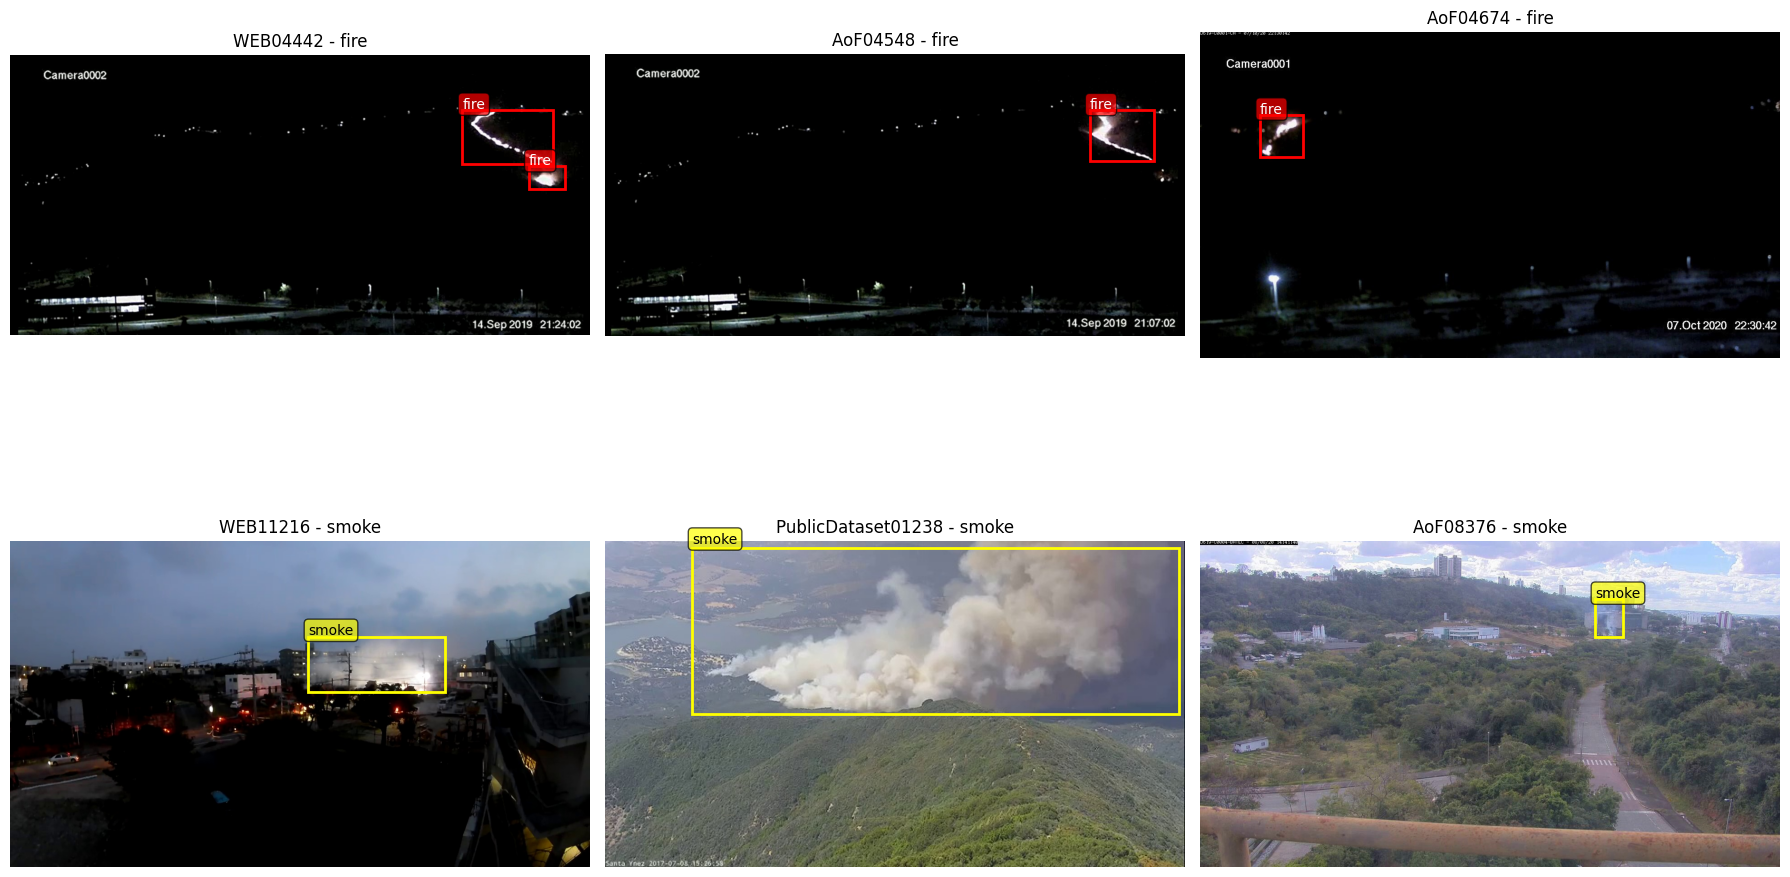

In [4]:
# Visualize sample images with bounding boxes
def visualize_sample(entry, ax=None):
    """Visualize a single image with its bounding boxes."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    image_path = Path(entry["image_path"])
    image = Image.open(image_path).convert("RGB")

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"{entry['image_id']} - {entry['image_label_name']}")

    # Draw bounding boxes
    colors = {1: 'red', 2: 'yellow'}  # fire=red, smoke=yellow
    for ann in entry["annotations"]:
        x1, y1, x2, y2 = ann["bbox_xyxy"]
        width = x2 - x1
        height = y2 - y1

        class_idx = ann["class_idx"]
        class_name = ann["class_name"]
        color = colors.get(class_idx, 'blue')

        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)

        ax.text(
            x1, y1 - 5, class_name,
            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7),
            fontsize=10, color='white' if color == 'red' else 'black'
        )

# Visualize a few samples from each split
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

idx = 0
for split_name in ['train', 'test']:
    if split_name in metadata["splits"]:
        entries = metadata["splits"][split_name]["entries"]
        # Get samples with annotations
        samples_with_boxes = [e for e in entries if e["num_annotations"] > 0][:3]

        for entry in samples_with_boxes:
            if idx < len(axes):
                visualize_sample(entry, axes[idx])
                idx += 1

plt.tight_layout()
plt.show()


## 2. Training Progress Visualization


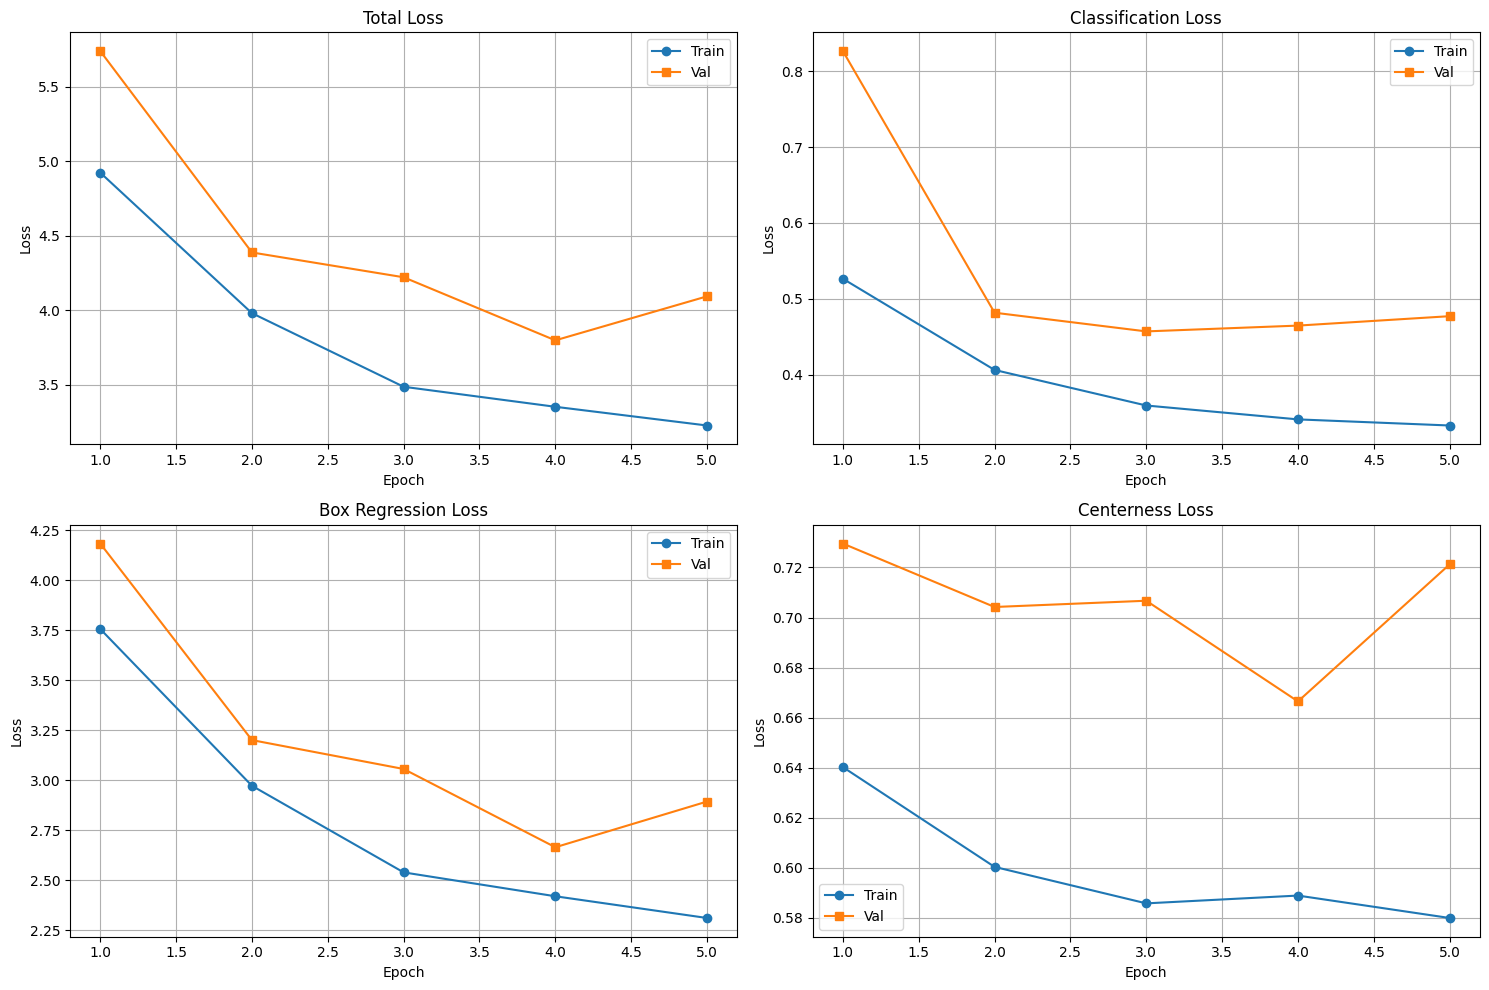

Best validation loss: 3.7968 at epoch 4


In [5]:
# Load training history (automatically handles both local and Colab paths)
history_path = project_root / "checkpoints" / "training_history.json"

if history_path.exists():
    with open(history_path, 'r') as f:
        history = json.load(f)

    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot training curves
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Total loss
    axes[0, 0].plot(epochs, history["train_loss"], label='Train', marker='o')
    axes[0, 0].plot(epochs, history["val_loss"], label='Val', marker='s')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Classification loss
    axes[0, 1].plot(epochs, history["train_cls"], label='Train', marker='o')
    axes[0, 1].plot(epochs, history["val_cls"], label='Val', marker='s')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Classification Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Box regression loss
    axes[1, 0].plot(epochs, history["train_box"], label='Train', marker='o')
    axes[1, 0].plot(epochs, history["val_box"], label='Val', marker='s')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Box Regression Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Centerness loss
    axes[1, 1].plot(epochs, history["train_ctr"], label='Train', marker='o')
    axes[1, 1].plot(epochs, history["val_ctr"], label='Val', marker='s')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Centerness Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Best validation loss: {min(history['val_loss']):.4f} at epoch {history['val_loss'].index(min(history['val_loss'])) + 1}")
else:
    print("Training history not found. Run training first.")


## 3. Training Setup and Configuration


In [6]:
# Training configuration
# (Imports already done in cell 1)

# Configuration - adjust these as needed
# Paths automatically work for both local and Colab
config = {
    "metadata_path": project_root / "dfire_detection_annotations.json",
    "batch_size": 32,
    "num_epochs": 50,
    "learning_rate": 0.001,
    "target_size": 800,
    "num_workers": 4 if not IN_COLAB else 2,  # Colab sometimes has issues with more workers
    "fpn_channels": 64,
    "stem_channels": [64, 64],
    "checkpoint_dir": project_root / "checkpoints",
    "log_dir": project_root / "logs",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

# Create directories
config["checkpoint_dir"].mkdir(parents=True, exist_ok=True)
config["log_dir"].mkdir(parents=True, exist_ok=True)

# Setup TensorBoard
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_subdir = config["log_dir"] / f"run_{timestamp}"
writer = SummaryWriter(log_dir=str(log_subdir))

print(f"Training configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")
print(f"\nTensorBoard logs: {log_subdir}")
print(f"To view: tensorboard --logdir {config['log_dir']}")


Training configuration:
  metadata_path: /content/drive/MyDrive/fire-detection/dfire_detection_annotations.json
  batch_size: 32
  num_epochs: 50
  learning_rate: 0.001
  target_size: 800
  num_workers: 2
  fpn_channels: 64
  stem_channels: [64, 64]
  checkpoint_dir: /content/drive/MyDrive/fire-detection/checkpoints
  log_dir: /content/drive/MyDrive/fire-detection/logs
  device: cuda

TensorBoard logs: /content/drive/MyDrive/fire-detection/logs/run_20251207_203051
To view: tensorboard --logdir /content/drive/MyDrive/fire-detection/logs


In [7]:
# Initialize model
num_classes = 2  # fire and smoke
model = FCOS(
    num_classes=num_classes,
    fpn_channels=config["fpn_channels"],
    stem_channels=config["stem_channels"],
)
model.to(config["device"])

print(f"Model initialized:")
print(f"  Classes: {num_classes} (0=fire, 1=smoke)")
print(f"  FPN channels: {config['fpn_channels']}")
print(f"  Stem channels: {config['stem_channels']}")
print(f"  Device: {config['device']}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
Model initialized:
  Classes: 2 (0=fire, 1=smoke)
  FPN channels: 64
  Stem channels: [64, 64]
  Device: cuda
  Total parameters: 5,434,695
  Trainable parameters: 5,434,695


In [8]:
# Create dataloaders
print("Creating dataloaders...")
train_loader, val_loader = create_dataloaders(
    config["metadata_path"],
    batch_size=config["batch_size"],
    target_size=config["target_size"],
    num_workers=config["num_workers"],
    train_augment=True,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val samples: {len(val_loader.dataset)}")


Creating dataloaders...
Train batches: 146
Val batches: 17
Train samples: 4650
Val samples: 516


In [9]:
# Setup optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

print(f"Optimizer: Adam (lr={config['learning_rate']})")
print(f"Scheduler: StepLR (step_size=20, gamma=0.1)")

# Training history
training_history = {
    "train_loss": [],
    "val_loss": [],
    "train_cls": [],
    "train_box": [],
    "train_ctr": [],
    "val_cls": [],
    "val_box": [],
    "val_ctr": [],
}

best_val_loss = float('inf')
start_epoch = 1

# Optional: Resume from checkpoint
resume_path = None  # Set to project_root / "checkpoints" / "best_model.pth" to resume

if resume_path and resume_path.exists():
    print(f"\nResuming from checkpoint: {resume_path}")
    checkpoint = torch.load(resume_path, map_location=config["device"])
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if "scheduler_state_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_loss = checkpoint.get("val_loss", float('inf'))
    print(f"Resuming from epoch {start_epoch}, best val loss: {best_val_loss:.4f}")
else:
    print("\nStarting fresh training")


Optimizer: Adam (lr=0.001)
Scheduler: StepLR (step_size=20, gamma=0.1)

Starting fresh training


## 4. Training Functions


In [10]:
# Training and validation functions
def train_epoch(model, dataloader, optimizer, device, epoch, writer=None):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    total_cls_loss = 0.0
    total_box_loss = 0.0
    total_ctr_loss = 0.0
    num_batches = 0

    for batch_idx, (images, gt_boxes) in enumerate(dataloader):
        images = images.to(device)
        gt_boxes = gt_boxes.to(device)

        # Forward pass
        losses = model(images, gt_boxes=gt_boxes)

        # Compute total loss
        total_loss_batch = (
            losses["loss_cls"] +
            losses["loss_box"] +
            losses["loss_ctr"]
        )

        # Backward pass
        optimizer.zero_grad()
        total_loss_batch.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += total_loss_batch.item()
        total_cls_loss += losses["loss_cls"].item()
        total_box_loss += losses["loss_box"].item()
        total_ctr_loss += losses["loss_ctr"].item()
        num_batches += 1

        # Log to tensorboard
        if writer and batch_idx % 10 == 0:
            global_step = epoch * len(dataloader) + batch_idx
            writer.add_scalar("Train/BatchLoss", total_loss_batch.item(), global_step)
            writer.add_scalar("Train/BatchClsLoss", losses["loss_cls"].item(), global_step)
            writer.add_scalar("Train/BatchBoxLoss", losses["loss_box"].item(), global_step)
            writer.add_scalar("Train/BatchCtrLoss", losses["loss_ctr"].item(), global_step)

        if (batch_idx + 1) % 10 == 0:
            print(
                f"  Batch {batch_idx + 1}/{len(dataloader)}, "
                f"Loss: {total_loss_batch.item():.4f} "
                f"(cls: {losses['loss_cls'].item():.4f}, "
                f"box: {losses['loss_box'].item():.4f}, "
                f"ctr: {losses['loss_ctr'].item():.4f})"
            )

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    avg_cls = total_cls_loss / num_batches if num_batches > 0 else 0.0
    avg_box = total_box_loss / num_batches if num_batches > 0 else 0.0
    avg_ctr = total_ctr_loss / num_batches if num_batches > 0 else 0.0

    return avg_loss, avg_cls, avg_box, avg_ctr


def validate(model, dataloader, device, epoch, writer=None):
    """Validate model."""
    model.eval()
    total_loss = 0.0
    total_cls_loss = 0.0
    total_box_loss = 0.0
    total_ctr_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, gt_boxes in dataloader:
            images = images.to(device)
            gt_boxes = gt_boxes.to(device)

            losses = model(images, gt_boxes=gt_boxes)
            total_loss_batch = (
                losses["loss_cls"] +
                losses["loss_box"] +
                losses["loss_ctr"]
            )

            total_loss += total_loss_batch.item()
            total_cls_loss += losses["loss_cls"].item()
            total_box_loss += losses["loss_box"].item()
            total_ctr_loss += losses["loss_ctr"].item()
            num_batches += 1

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    avg_cls = total_cls_loss / num_batches if num_batches > 0 else 0.0
    avg_box = total_box_loss / num_batches if num_batches > 0 else 0.0
    avg_ctr = total_ctr_loss / num_batches if num_batches > 0 else 0.0

    # Log to tensorboard
    if writer:
        writer.add_scalar("Val/Loss", avg_loss, epoch)
        writer.add_scalar("Val/ClsLoss", avg_cls, epoch)
        writer.add_scalar("Val/BoxLoss", avg_box, epoch)
        writer.add_scalar("Val/CtrLoss", avg_ctr, epoch)

    return avg_loss, avg_cls, avg_box, avg_ctr

print("Training functions defined")


Training functions defined


## 5. Training Loop

In [11]:
# Training loop - Run this cell to train all epochs
for epoch in range(start_epoch, config["num_epochs"] + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{config['num_epochs']}")
    print(f"{'='*60}")

    # Train
    train_loss, train_cls, train_box, train_ctr = train_epoch(
        model, train_loader, optimizer, config["device"], epoch, writer
    )
    print(f"\nTrain Loss: {train_loss:.4f} (cls: {train_cls:.4f}, box: {train_box:.4f}, ctr: {train_ctr:.4f})")

    # Validate
    val_loss, val_cls, val_box, val_ctr = validate(
        model, val_loader, config["device"], epoch, writer
    )
    print(f"Val Loss: {val_loss:.4f} (cls: {val_cls:.4f}, box: {val_box:.4f}, ctr: {val_ctr:.4f})")

    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar("Train/LearningRate", current_lr, epoch)
    print(f"Learning rate: {current_lr:.6f}")

    # Save checkpoint
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "train_loss": train_loss,
        "val_loss": val_loss,
    }

    checkpoint_path = config["checkpoint_dir"] / f"checkpoint_epoch_{epoch}.pth"
    torch.save(checkpoint, checkpoint_path)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_path = config["checkpoint_dir"] / "best_model.pth"
        torch.save(checkpoint, best_path)
        print(f"✓ Saved best model (val_loss: {val_loss:.4f})")

    # Update training history
    training_history["train_loss"].append(train_loss)
    training_history["val_loss"].append(val_loss)
    training_history["train_cls"].append(train_cls)
    training_history["train_box"].append(train_box)
    training_history["train_ctr"].append(train_ctr)
    training_history["val_cls"].append(val_cls)
    training_history["val_box"].append(val_box)
    training_history["val_ctr"].append(val_ctr)

    # Save training history
    history_path = config["checkpoint_dir"] / "training_history.json"
    with open(history_path, 'w') as f:
        json.dump(training_history, f, indent=2)

writer.close()
print("\n" + "=" * 60)
print("Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Checkpoints saved to: {config['checkpoint_dir']}")
print(f"Logs saved to: {log_subdir}")



Epoch 1/50
  Batch 10/146, Loss: 5.6571 (cls: 0.5794, box: 4.2524, ctr: 0.8253)
  Batch 20/146, Loss: 5.3712 (cls: 0.6881, box: 4.0965, ctr: 0.5866)
  Batch 30/146, Loss: 6.4992 (cls: 0.6638, box: 5.0422, ctr: 0.7932)
  Batch 40/146, Loss: 4.8023 (cls: 0.4371, box: 3.7624, ctr: 0.6028)
  Batch 50/146, Loss: 6.1329 (cls: 0.4751, box: 4.8962, ctr: 0.7616)
  Batch 60/146, Loss: 3.4480 (cls: 0.3777, box: 2.6119, ctr: 0.4583)
  Batch 70/146, Loss: 5.8346 (cls: 0.4644, box: 4.6680, ctr: 0.7021)
  Batch 80/146, Loss: 5.9250 (cls: 0.5427, box: 4.7089, ctr: 0.6734)
  Batch 90/146, Loss: 4.7982 (cls: 0.3353, box: 3.9023, ctr: 0.5606)
  Batch 100/146, Loss: 2.7573 (cls: 0.3458, box: 2.0064, ctr: 0.4051)
  Batch 110/146, Loss: 3.0355 (cls: 0.3304, box: 2.2321, ctr: 0.4730)
  Batch 120/146, Loss: 2.1279 (cls: 0.2979, box: 1.5291, ctr: 0.3009)
  Batch 130/146, Loss: 5.4631 (cls: 0.5091, box: 4.1735, ctr: 0.7805)
  Batch 140/146, Loss: 5.2615 (cls: 0.7489, box: 3.8393, ctr: 0.6733)

Train Loss: 5.02

KeyboardInterrupt: 

## 6. Inference and Visualization


In [12]:
# Load trained model
# Note: If you trained in this notebook, the model is already loaded above
# This cell is for loading a previously trained model
checkpoint_path = project_root / "checkpoints" / "best_model.pth"

# Option 1: Use the model from training (if you ran training cells above)
# The model variable is already available from the training setup

# Option 2: Load a previously trained model from checkpoint
if 'model' not in globals() or model is None:
    if checkpoint_path.exists():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model (adjust parameters to match your training)
        num_classes = 2  # fire and smoke
        model = FCOS(
            num_classes=num_classes,
            fpn_channels=64,
            stem_channels=[64, 64],
        )

        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.to(device)
        model.eval()

        print(f"Loaded model from epoch {checkpoint['epoch']}")
        print(f"Validation loss: {checkpoint['val_loss']:.4f}")
    else:
        print("Model checkpoint not found. Train a model first.")
        model = None
        device = None
else:
    # Use the model from training
    device = config["device"]
    model.eval()
    print("Using model from training setup above")


Using model from training setup above


In [15]:
def visualize_predictions(image_path, model, device, score_thresh=0.3, nms_thresh=0.5, target_size=800):
    """Run inference on an image and visualize predictions."""
    if model is None:
        print("Model not loaded.")
        return

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    original_size = image.size  # (width, height)

    # Resize and normalize
    transform = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)

    # Run inference
    with torch.no_grad():
        pred_boxes, pred_classes, pred_scores = model(
            image_tensor,
            test_score_thresh=score_thresh,
            test_nms_thresh=nms_thresh,
        )

    # Scale boxes back to original image size
    scale_w = original_size[0] / target_size
    scale_h = original_size[1] / target_size

    pred_boxes = pred_boxes.cpu().numpy()
    pred_classes = pred_classes.cpu().numpy()
    pred_scores = pred_scores.cpu().numpy()

    # Scale boxes
    pred_boxes[:, [0, 2]] *= scale_w
    pred_boxes[:, [1, 3]] *= scale_h

    # Visualize
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)
    ax.axis('off')

    colors = {0: 'red', 1: 'yellow'}  # fire=0 (red), smoke=1 (yellow)
    class_names = {0: 'fire', 1: 'smoke'}

    for box, cls, score in zip(pred_boxes, pred_classes, pred_scores):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1

        color = colors.get(int(cls), 'blue')
        class_name = class_names.get(int(cls), f'class_{cls}')

        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)

        label_text = f"{class_name}: {score:.2f}"
        ax.text(
            x1, y1 - 5, label_text,
            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7),
            fontsize=10, color='white' if color == 'red' else 'black'
        )

    ax.set_title(f"Detections: {len(pred_boxes)} objects found", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return pred_boxes, pred_classes, pred_scores

# Run inference on a few test images
if model is not None and device is not None:
    test_entries = metadata["splits"]["test"]["entries"][-15:]

    for entry in test_entries:
        image_path = Path(entry["image_path"])
        print(f"\nProcessing: {entry['image_id']}")
        visualize_predictions(image_path, model, device)
else:
    print("Model not loaded. Cannot run inference.")


Output hidden; open in https://colab.research.google.com to view.